<a href="https://colab.research.google.com/github/pachterlab/GFCP_2021/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies


In [ ]:
#!git clone https://github.com/pachterlab/GFCP_2021.git
#!cd GFCP_2021
#from vis import * 

In [ ]:
%%capture
pip install scvelo==0.2.3 --quiet

In [ ]:
%%capture
pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git

In [ ]:
%%capture
pip install scanpy

In [ ]:
%%capture
pip install umap-learn

In [ ]:
!mkdir figure notebook

In [ ]:
%cd notebook
!mkdir data

/content/notebook


In [ ]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")

('data/hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7f5dcbace0d0>)

# vis.py

## simulation

In [ ]:

# ---------------- Simulation -------------
def eval_x_interval(k_,dt,beta,gamma,x0):
    '''
    Evaluates a single gene's average expression at a time point dt after
    the system is started. This solution results from the reaction 
    rate equations, and is specifically implemented for a time interval wherein
    the parameter values are constant.
    
    Parameters
    ----------
    k_: transcription rate (constitutive)
    dt: time since system is started
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    gamma /= beta
    dt *= beta
    k_ /= beta
    x = np.array([k_*(1-np.exp(-dt)) + x0[0]*np.exp(-dt), 
        np.exp(-dt*gamma) * \
        (np.exp(dt*gamma) * k_ * (gamma-1) + \
        - k_*np.exp(dt*(gamma-1))*gamma \
        + k_\
        + (gamma-1)*gamma*x0[1] \
        +gamma*x0[0]*(np.exp((gamma-1)*dt)-1)) \
        /gamma/(gamma-1)])
    return x

def eval_x(k,tau,t,beta,gamma):
    '''
    Evaluates a single gene's average expression at a time point t. 
    This solution derives from the reaction rate equations. The value is 
    computed by evaluating the RREs piecewise over succeeding intervals 
    until time t is reached. 
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0 (in this case, we assume it starts with Poisson)
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    # x=x0
    x0 = [k[0]/beta, k[0]/gamma]
    x=x0
    ind_last = sum(tau<=t)
    tau = np.concatenate((tau[:(ind_last)],[t]))
    for ind in range(ind_last):
        x = eval_x_interval(k[ind],tau[ind+1]-tau[ind],beta,gamma,x)
    return x

def poiss_samp(k,tau,t,beta,gamma):
    '''
    Simulates a single gene's expression at a time point t. 
    This solution derives from the reaction rate equations. The average 
    expression is computed; then, a Poisson random variable with that 
    expectation is sampled to produce an observation. 
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: instantaneous expression (vector, unspliced and spliced)
    '''
    x = np.random.poisson(eval_x(k,tau,t,beta,gamma))
    return x

def get_cell_spec_K(K,cell_type):
    k = [K[0],K[1],K[cell_type]]
    return np.array(k)

def simulate_occup_meas(nCells=2000, nGenes=100, T=30, tau = [0,8,13], topo="aba"):
    '''
    Simulates a gene expression given a constitutive model with transient
    dynamics. A vector of observation times is initializated; then, the 
    occupation measures are sampled to produce single-molecule observations
    consistent with canonical RNA velocity models.
    
    Parameters
    ----------
    nCells: number of cells to simulate
    nGenes: number of genes to simulate
    T: process halting time
    tau: process-wide transition times
    topo: string indicating whether the process topology. This defines the 
    transcription rate arrays K over the trajectory.
        "aba": cells are perturbed and return back to the original attractor.
            2 parameters. 
        "ab(a/c)": cells are perturbed; half return and half seek a new attractor.
            3 parameters (one is duplicated).
        "ab(c/d)" cells branch to attractors c and d through b.
            4 parameters.
        "ab(c/d/e)" cells branch to attractors c, d and e through b.
            5 parameters.
    Returns
    -------
    X: spliced and unspliced samples from occupation measure
        (array, 2 x nCells x nGenes)
    branch_cells: indices of cells that branch off
    tvec: ground truth pseudotimes
    K: ground truth initiation rates
    g_true: ground truth degradation rates
    b_true: ground truth splicing rates (all 1)
    '''
    #define occupation measure for sampling: df = dt/T
    tvec = np.random.rand(nCells)*T
    tau.append(T)
    #initialize arrays for simulations
    X = np.zeros((2,nCells,nGenes))
    g_true = np.zeros(nGenes)
    b_true = np.zeros(nGenes)
    cell_types = np.zeros(nCells,dtype=int)

    cell_types[tvec<=tau[1]] = 0 #a
    cell_types[(tvec>tau[1]) & (tvec<tau[2])] = 1
    #print(cell_types)
    if topo == "aba":
        # one fate topo
        n_K = 2
        cell_types[tvec>tau[2]] = 0
        # print("aba")
    elif topo == "ab(c/d/e)":
        # three fates topo
        n_K = 5
        cell_fate=np.random.randint(3,size=nCells)
        cell_types[(tvec>tau[2]) & (cell_fate==0)] = 2
        cell_types[(tvec>tau[2]) & (cell_fate==1)] = 3
        cell_types[(tvec>tau[2]) & (cell_fate==2)] = 4
        print("ab(c/d/e)")
        #print(cell_types)
    else:
        # two fates topo
        n_branch_cells = int(nCells/2)
        branch_cells = np.random.choice(nCells,n_branch_cells,False)
        filt = np.zeros(nCells,dtype=bool)
        filt[branch_cells] = True
        if topo == "ab(a/c)":
            n_K = 3
            cell_types[(tvec>tau[2]) & ~filt] = 0
            cell_types[(tvec>tau[2]) & filt] = 2
            print("ab(a/c)")
        if topo == "ab(c/d)":
            n_K = 4
            cell_types[(tvec>tau[2]) & ~filt] = 2
            cell_types[(tvec>tau[2]) & filt] = 3
            print("ab(c/d)")
    # print(cell_types)
    K = np.zeros((nGenes,n_K))


    for j in range(nGenes):
        # print(j)
        FLAG = True
        while FLAG:
            #this defines states a, b, c, d, e.
            kinit = 10**np.random.normal(1,size=n_K)
            K[j,:] = kinit
            # print(kinit)
            beta = 10**np.random.normal(0,1)
            b_true[j]=beta
            gamma = 10**np.random.normal(0,1)
            g_true[j] = gamma

            try: #the simulation procedure is not necessarily stable. If it
                #produces unreasonable samples, we resample the parameters.
                for i in range(nCells):
                    # print(nCells)
                    # x0 = [kinit[0]/beta, kinit[0]/gamma]
                    X[:,i,j]= poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                    # print(i)
                    # if i==0:
                    #     print(K[j,cell_types[i]])
                    #     print(tvec[i])
            except:
                # print(kinit)
                # print(x0)
                # print('big yikes')
                # poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                pass
            
            if ~np.any(np.isnan(X[:,:,j])):
                FLAG=False
    return X,cell_types,tvec,K,g_true,b_true,tau

def sim_export(simdata, name="simdata"):
    X,cell_types,tvec,K,g_true,b_true,tau= simdata
    adata=ad.AnnData(np.sum(X,axis=0))
    adata.layers["spliced"] = X[1,:,:]
    adata.layers["unspliced"] = X[0,:,:]
    adata.layers["ambiguous"]=np.zeros((nCells,nGenes))
    # br = np.zeros(nCells,dtype=bool)
    # br[branch_cells]=True
    adata.obs["time"]=tvec
    ## cluster time
    ctime=tvec.copy()
    ctime[cell_types==0]=ctime[cell_types==0]/tau[1]
    ctime[cell_types==1]=(ctime[cell_types==1]-tau[1])/(tau[2]-tau[1])
    ctime[cell_types==2]=(ctime[cell_types==2]-tau[2])/(tau[3]-tau[2])
    ctime[cell_types==3]=(ctime[cell_types==3]-tau[2])/(tau[3]-tau[2])
    ctime[cell_types==4]=(ctime[cell_types==4]-tau[2])/(tau[3]-tau[2])
    adata.obs["ctime"]=ctime
    adata.obs["celltype"]=cell_types
    adata.var["gamma"]=g_true
    adata.var["beta"]=b_true
    adata.var["Gene"]=np.asarray([str(i) for i in range(nGenes)])
    # adata.uns["K"]=K
    n_K = K.shape[1]
    for i in range(n_K):
        adata.var["k"+str(i)]=K[:,i]
    # adata.var["km"]=K[:,1]
    # adata.var["k1"]=K[:,2]
    # adata.var["k2"]=K[:,3]
    # adata.uns['tau']=tau
    adata.write_loom(name+".loom")

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
import umap

import velocyto as vcy
import anndata as ad
import warnings

import scvelo as scv

## velocyto

In [ ]:
#For vlm need to save linear/non-linear pca,t-SNE,UMAP,  and true pseudotime/gamma, cluster labels


# parameter
vermeer_hex = ("#A65141", "#E7CDC2", "#80A0C7", "#394165", "#FCF9F0", "#B1934A",
             "#DCA258", "#100F14", "#8B9DAF", "#EEDA9D")
vermeer = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_hex] 
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
                     
emb_dict={"default":'pcs',"PCA":"ps", "UMAP":"us", "tSNE":"ts"}
    

def preprocess(vlm,nGene=2000, sim=False, filter=True,):
    if filter:
        vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
        vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
        vlm.filter_genes(by_detection_levels=True)
        vlm.score_cv_vs_mean(N=nGene, plot=False, max_expr_avg=35)
        vlm.filter_genes(by_cv_vs_mean=True)

    vlm.normalize("both", size=True, log=True)
    vlm.perform_PCA(which="S_norm")
    vlm.pcs=vlm.pcs[:,:2]
    
    if sim:
        ctime=vlm.ca["ctime"]
        labels=vlm.ca["celltype"]
        cluster_colors_dict={l:colors20[l % 20,:] for l in labels}
        vlm.colors=[cluster_colors_dict[label] for label in labels]
        vlm.colors=vlm.colors*(0.6+0.4*(1-ctime))[:,None]
    else:
        labels = vlm.ca["Clusters"]
        cluster_colors_dict={l:colors20[l % 20,:] for l in labels}
        vlm.colors=[cluster_colors_dict[label] for label in labels]
    return


def makeEmbeds(vlm, embeds, x_name="S_norm", new_pca=True):
    '''
    Save embedding objects in embeds lists in vlm
    
    Parameters
    ----------
    vlm : Velocyto loompy object
    x_name: X for embedding, e.g. "S", "S_norm"
    embeds : set of embeddings e.g. {'PCA','UMAP','tSNE'}
    
    Returns
    -------
    '''    
    
    if new_pca or not hasattr(vlm, "PCA"):
        X = getattr(vlm, x_name) # X=(n_samples, n_features)
        vlm.PCA = PCA(n_components=50).fit_transform(X.T)
        
    
    if "PCA" in embeds:
        vlm.ps = np.array(vlm.PCA[:,:2], order="C")
        
    if 'UMAP' in embeds:
        vlm.us = umap.UMAP(n_components=2).fit_transform(vlm.PCA[:, :25])
        
    if 'tSNE' in embeds:
        vlm.ts = TSNE(n_components=2).fit_transform(vlm.PCA[:, :25]) 

    if "default" in embeds:
        vlm.perform_PCA(which=x_name) # default add attr pca and pcs

    return 


def getImputed(vlm, knn_k=50):
    '''
    Get gamma inference from imputed counts
    
    Parameters
    ----------
    
    Returns
    -------
    '''

    vlm.knn_imputation(k=knn_k)
    vlm.normalize("imputed", size=True, log=True)

    #Get gamma inference
    delta_t = 1
    vlm.used_delta_t = delta_t
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
        
    vlm.delta_S = vlm.Ux_sz - vlm.gammas[:,None] * vlm.Sx_sz # same as vlm.predict_U() and vlm.calculate_velocity()
    vlm.Sx_sz_t = vlm.Sx_sz + delta_t * vlm.delta_S  # same as vlm.extrapolate_cell_at_t(delta_t=1)

    return


def getNeighbors(embed, n_neigh = 150, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(x1, x2, n_neigh=150):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    embed1_neighbor = getNeighbors(x1,n_neigh)
    embed2_neighbor = getNeighbors(x2,n_neigh)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        frac[i] = 1-len(inter)/len(set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:]))
    return frac

# def princCurveCompute(ax,vlm,meta):
#     '''
#     Plot principal curve coordinates for linear PCA embedding
    
#     Parameters
#     ----------
    
#     Returns
#     -------
#     '''
#     return


# ---------------- Plotting -------------


def princCurvePlots(ax,vlm,meta):
    '''
    Plot principal curve coordinates for linear PCA embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    nCells,nGenes,T,tau,topo = meta
    nT = 200
    tvec_red = np.linspace(np.min(vlm.ca['time']),np.max(vlm.ca['time']),nT)
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4,"ab(c/d/e)":5}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3],"ab(c/d/e)":[2,3,4]}
    n_K = dict_nk[topo]
    
    branches = dict_Kval[topo]
    n_branches = len(branches)
    for i in range(n_branches):
        K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
        Xtheo = [[eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec_red] for j in range(nGenes)]
        Xtheo = np.asarray(Xtheo)
        Xtheo[np.isnan(Xtheo)]=0
        Xtheo[np.isinf(Xtheo)]=0
        Xtheo = np.swapaxes(Xtheo,0,2)

        # print(got)
        Y = vlm.pca.transform(np.log2(Xtheo[1,:,:]+1))
        ax.plot(Y[:,0],Y[:,1],c='k',alpha=0.5)

    # princCurveCompute(ax,vlm,meta)
    return

def plotJaccard(ax,x1, x2, n_neigh=150):
    '''
    Single jaccard distance plot
    
    Parameters
    ----------
    ax: plot axis
    vlm: velocyto 
    Returns
    -------
    '''
    frac=getJaccard(x1, x2, n_neigh)
    ax.hist(frac, color = vermeer[3], lw=0)
    #ax.set_title('Jaccard distances for neighbors between ' + pair[0] + ' and '  + pair[1])
    return frac

    
    
def plotPhase(ax, vlm, gene_idx):
    '''
    Plot phase portrait
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    y=vlm.Ux[gene_idx,:]
    x=vlm.Sx[gene_idx,:]
    k=vlm.gammas[gene_idx]
    b=vlm.q[gene_idx]
    
    ax.scatter(x, y, c=vlm.colors)
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    x_=np.array([np.amin(x), np.amax(x)])
    ax.plot(x_, x_*k+b, color=vermeer[0],linewidth=4)
    return

def plotGammaK(ax, vlm, gene_idx, n_neigh, gamma, q, sim=False):
    '''
    Plot gamma over k neighbors for gene at gene_idx
    
    Parameters
    ----------
    
    Returns
    -------
    
    '''
    ax.plot(n_neigh, gamma, color=vermeer[0],label="gamma",lw=6)
    if sim:
        ax.plot(n_neigh,vlm.ra["gamma"][gene_idx]/vlm.ra["beta"][gene_idx]*np.ones(len(n_neigh)),'r-',label="true gamma")
    ax.set_xlabel("k neighbors")
    ax.set_ylabel("gamma")
    ax.yaxis.label.set_color(vermeer[0])
    frac=vlm.Ux[gene_idx,:,None] - vlm.Sx[gene_idx,:,None]*gamma[None,:] + q[None,:]
    frac=np.sum(frac>0,axis=0)/np.shape(frac)[0]
    ax2=ax.twinx()
    ax2.plot(n_neigh, frac, color=vermeer[3],label="frac",lw=6)
    ax2.set_ylabel("perc cells unregulated")
    ax2.yaxis.label.set_color(vermeer[3])
    ax2.set_ylim([0,1])
    return

def phasePlots(vlm,genes, n_neighs,n_neighs_list,sim=False):
    '''
    Plot phase portrais with gamma distributions for various genes across n_neighs
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    if type(genes) is list or type(genes) is tuple: #looking at SPECIFIC genes enumerated in an iterable
        m = len(genes)
    else: #just some random genes
        m = genes
        genes = np.random.choice(vlm.ra['Gene'],m,replace=False)
    
    
    n = len(n_neighs)
    n2 = len(n_neighs_list)
    gammas = np.zeros((m,n2))
    q = np.zeros((m,n2))
    
    fig, ax = plt.subplots(m,n+1,figsize=((n+1)*6,m*4))
    
    # generate phase plots
    for j, knn_k in enumerate(n_neighs):      
        if knn_k>0:
            vlm.knn_imputation(k=knn_k)
            vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
   
        else:
            vlm.Sx=vlm.S
            vlm.Ux=vlm.U  
            vlm.gammas=np.zeros(len(vlm.S))
            vlm.q=np.zeros(len(vlm.S))
            ## vlm fit_gammas is not working!!! use sklearn linear regression instead
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                reg = LinearRegression().fit(vlm.S[gene_idx,:].reshape(-1,1), vlm.U[gene_idx,:].reshape(-1,1))
                vlm.gammas[gene_idx]=reg.coef_
                vlm.q[gene_idx]=reg.intercept_
                
        # Plot phase plots
        for i, gene in enumerate(genes):
            gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
            plotPhase(ax[i][j], vlm, gene_idx)    

        
            
    for j, k in enumerate(n_neighs_list):
        knn_k=int(k)
        if knn_k>0:
            vlm.knn_imputation(k=knn_k)
            vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                gammas[i,j]=vlm.gammas[gene_idx]
                q[i,j]=vlm.q[gene_idx]
        else:
            vlm.Sx=vlm.S
            vlm.Ux=vlm.U   
            ## vlm fit_gammas is not working!!! use sklearn linear regression instead
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                reg = LinearRegression().fit(vlm.S[gene_idx,:].reshape(-1,1), vlm.U[gene_idx,:].reshape(-1,1))
                gammas[i,j]=reg.coef_
                q[i,j]=reg.intercept_
            
    for i, gene in enumerate(genes):
        gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
        plotGammaK(ax[i][n], vlm, gene_idx, n_neighs_list, gammas[i,:], q[i,:], sim=sim)
    return fig


def plotEmbed(ax,vlm,embed):
    '''
    Plot given embedding (UMAP, t-SNE, etc)
    
    Parameters
    ----------
    c: colors

    Returns
    -------
    '''
    x=getattr(vlm, embed)
    ax.scatter(x[:,0],x[:,1],marker=".",c=vlm.colors, alpha=0.5,edgecolors="none")
    return


def plotGrid(ax,vlm,gridx,gridv,trans, scale=5, c="gray"):
    '''
    Plot grid with arrows given embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    x=getattr(vlm, gridx)
    v=getattr(vlm, gridv)
    masks=vlm.total_p_mass>0.01
    ax.quiver(x[masks, 0], x[masks, 1], v[masks, 0], v[masks, 1], linewidth=6.5, scale=scale, label=trans, alpha=0.8, color=c)   
    return

def linear_embed(vlm):
    '''
    Linear embed the velocity
    
    Parameters
    ----------
    
    Returns
    -------
    v: velocity arrows for each cell
    '''
    delta_S_sz = vlm.U_sz - vlm.gammas[:,None] * vlm.S_sz # same as vlm.predict_U() and vlm.calculate_velocity()    
    mask=delta_S_sz<-1e-6
    delta_t=np.min(vlm.S_sz[mask]/np.abs(delta_S_sz[mask]))
    vlm.S_sz_t = vlm.S_sz + delta_t/2 * delta_S_sz  # same as vlm.extrapolate_cell_at_t(delta_t=1)
    v=vlm.pca.transform(np.log2(vlm.S_sz_t.T+1))[:,:2]-vlm.pcs[:,:2]
    return v


def gridArrowPlots(vlm,Trans,embed,sim=False,meta=None,ax=None,legend=True,quiver_scale=5):
    '''
    Plot arrow embeddings for vlm data with defined count transformations
    
    Parameters
    ----------
    sim: boolean to look for true pseudotime or cluster and/or principal curve
    
    Returns
    -------
    
    '''
    if not hasattr(vlm,"delta_S"):
        getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='S_norm', new_pca=False)
    emb=emb_dict[embed]
    if ax is None:
        fig,ax=plt.subplots(1,1)
        
    plotEmbed(ax,vlm,emb)
    
    # plot baseline arrows or curves
    if embed=="PCA":
        if sim:
            princCurvePlots(ax,vlm,meta)
        else:
            v=linear_embed(vlm)
            ax.quiver(vlm.pcs[:,0], vlm.pcs[:,1], v[:, 0], v[:, 1], alpha=0.5, linewidth=6.5, scale=5, label="baseline")       

    for i,trans in enumerate(Trans):        
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                n_neighbors=150, knn_random=False, sampled_fraction=1)

        if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
            warnings.warn("Nan values in corrcoef, setting them to 0") 
            vlm.corrcoef[np.isnan(vlm.corrcoef)]=0

        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        vlm.calculate_grid_arrows(smooth=0.5, steps=(10, 10), n_neighbors=100)

        plotGrid(ax,vlm,"flow_grid","flow",trans, scale=quiver_scale, c=vermeer[-2-i])
        
    if legend:
        ax.legend()
    if ax is None:
        return fig
    else:
        return ax



def plotTheta(ax, X, Y, k):
    '''
    Single angle deviation plot
    '''
    angle1=np.arctan2(X[:,1],X[:,0])
    angle2=np.arctan2(Y[:,1],Y[:,0])
    angle=angle2-angle1
    angle[angle>np.pi]=angle[angle>np.pi]-2*np.pi
    angle[angle<-np.pi]=angle[angle<-np.pi]+2*np.pi
    ax.hist(angle,density=True,label=str(k),alpha=0.2)
    ax.set_xlabel("angle")
    ax.set_ylabel("density")
    return 

def angleDevPlots(vlm,Trans,n_neighs):
    '''
    Plot angle deviations from transformations over varying neighbors for embedding (only compared to baseline)
    
    Parameters
    ----------

    Returns
    -------
    '''    
    if not hasattr(vlm,"delta_S"):
        getImputed(vlm, knn_k=50)
    fig, ax= plt.subplots(1, len(Trans),figsize=(len(Trans)*6,4))
    baseline_arrow=linear_embed(vlm)
 
    for j, k in enumerate(n_neighs):
        for i,trans in enumerate(Trans):       
            vlm.estimate_transition_prob(hidim="S_sz", embed="pcs", transform=trans,
                                          n_neighbors=k, knn_random=False, sampled_fraction=1)
            if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
                warnings.warn("Nan values in corrcoef, setting them to 0") 
                vlm.corrcoef[np.isnan(vlm.corrcoef)]=0
                
            vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
            
            plotTheta(ax[i], baseline_arrow, vlm.delta_embedding, k)
            
    plt.legend()
        
    return fig



In [ ]:
# def simPdfPlot(ax,vlm):
#     pmf_nas = get_nas(K,tau,T,beta,np.max(Xg[0]))
#     pmf_mat = get_mat(K,tau,T,beta,gamma,np.max(Xg[1]))
def simValidPlots(vlm,tau,geneind=0,knn_k=50):
    '''
    Plot sim validation figures.
    These should be later combined into a single figure, instead of several.
    MAKE SURE THE IMPUTATION HAPPENS.
    '''
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.005))[0][0]
    vlm.knn_imputation(n_pca_dims=n_comps,k=knn_k, balanced=True, b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))



    fig1, ax1 = plt.subplots(1, 3,figsize=(3*6,4))
    vlm.fit_gammas(use_imputed_data=False, use_size_norm=False, weighted=False)
    plotGamma(ax1[0],vlm)
    vlm.fit_gammas(use_imputed_data=False, use_size_norm=True, weighted=True, weights="maxmin_diag")
    plotGamma(ax1[1],vlm)
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
    plotGamma(ax1[2],vlm)


    Xtheo = getGroundTruthAvg(vlm,tau)

    fig2, ax2 = plt.subplots(1, 3,figsize=(3*6,4))
    selection_names = ['raw','size_norm','imputed']
    for i in range(3):
        plotSimCounts(ax2[i],vlm,geneind,selection_names[i])
        plotGroundTruthCounts(ax2[i],vlm,geneind,tau)
    
    fig3, ax3 = plt.subplots(1, 2,figsize=(2*6,4))
    selection_names = ['U','S']
    for i in range(2):
        plotImpPerformance(ax3[i],vlm,Xtheo,selection_names[i])

def plotImpPerformance(ax,vlm,Xtheo,selection):
    if selection is 'U':
        field_str = 'Ux'
        i = 0
    elif selection is 'S':
        field_str = 'Sx'
        i = 1
    ground_truth = Xtheo[i].T.flatten()
    imputed_value = getattr(vlm,field_str).flatten()
    ax.loglog(ground_truth,imputed_value,'k.')
    xl = np.linspace(min(ground_truth),max(ground_truth))
    ax.plot(xl,xl,'r-',linewidth=2)
    ax.plot(xl,xl*10,'b-')
    ax.plot(xl,xl/10,'b-')
    ax.set_xlabel(selection + ' ground truth mean')
    ax.set_ylabel(selection + ' imputed mean')


def getGroundTruthAvg(vlm,tau):
    i=0  #just recycling the more generic code
    tvec = vlm.ca['time']
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    
    branches = dict_Kval[topo]
    n_branches = len(branches)

    i=0
    Xtheo = [[eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec] for j in range(nGenes)]
    Xtheo = np.asarray(Xtheo)
    Xtheo[np.isnan(Xtheo)]=0
    Xtheo[np.isinf(Xtheo)]=0
    Xtheo = np.swapaxes(Xtheo,0,2)
    return Xtheo

def plotGamma(ax,vlm):
    x = vlm.ra['gamma']/vlm.ra['beta']
    tmp = vlm.gammas
    vlm.gammas[vlm.gammas<1e-4]=1e-4
    ax.loglog(x,vlm.gammas,'k.')
    xl = np.linspace(min(x),max(x))
    ax.plot(xl,xl,'r-',linewidth=2)
    ax.plot(xl,xl*10,'b-')
    ax.plot(xl,xl/10,'b-')
    vlm.gammas = tmp

def plotSimCounts(ax,vlm,geneind,selection):
    if selection is 'raw':
        U_str = 'U'
        S_str = 'S'
    elif selection is 'size_norm':
        U_str = 'U_sz'
        S_str = 'S_sz'
    elif selection is 'imputed':
        U_str = 'Ux'
        S_str = 'Sx'
    U = getattr(vlm,U_str)[geneind,:]
    S = getattr(vlm,S_str)[geneind,:]
    tvec = vlm.ca['time']
    ax.plot(tvec,U,'.')
    ax.plot(tvec,S,'.')

def plotGroundTruthCounts(ax,vlm,geneind,tau):
    #there are better ways to do this

    j=geneind
    tvec = vlm.ca['time']
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    
    branches = dict_Kval[topo]
    n_branches = len(branches)

    i=0
    Xtheo = [eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec]
    Xtheo = np.asarray(Xtheo)
    Xtheo[np.isnan(Xtheo)]=0
    Xtheo[np.isinf(Xtheo)]=0

    I_ = np.argsort(tvec)
    tvec = tvec[I_]
    Xtheo = Xtheo[I_]
    ax.plot(tvec,Xtheo,linewidth=2)

    # x0 = [K[geneind,0],K[geneind,0]/g_true[geneind]]
    # plt.plot(tvec,[eval_x(K[geneind,:],tau,t,1,g_true[geneind],x0)[0] for t in tvec],'k.')
    # plt.plot(tvec,[eval_x(K[geneind,:],tau,t,1,g_true[geneind],x0)[1] for t in tvec],'r.')

### Forebrain data 

In [ ]:
vlm = vcy.VelocytoLoom(loom_filepath="data/hgForebrainGlut.loom")

In [ ]:
vlm.ca

{'CellID': array(['10X_17_028:AACCATGGTAATCACCx', '10X_17_028:AACCATGCATACTACGx',
        '10X_17_028:AAACCTGGTAAAGGAGx', ...,
        '10X_17_029:TTTGGTTGTACCCAATx', '10X_17_029:TTTCCTCCAGTCCTTCx',
        '10X_17_029:TTTGCGCCACAGATTCx'], dtype=object),
 'Clusters': array([3, 3, 1, ..., 6, 0, 1])}

In [ ]:
preprocess(vlm)

#### phasePlots

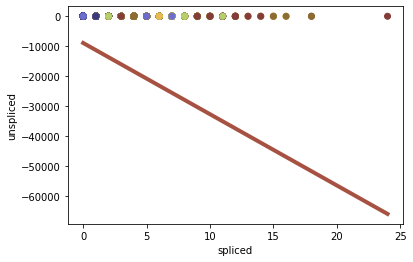

In [ ]:
fig,ax=plt.subplots(1,1)
vlm.Sx=vlm.S
vlm.Ux=vlm.U
vlm.fit_gammas(use_imputed_data=False, use_size_norm=False, weighted=False, weights=np.ones_like(vlm.S))
plotPhase(ax, vlm, gene_idx=int(np.where(vlm.ra['Gene']=="DCX")[0][0]))  

In [ ]:
from sklearn.linear_model import LinearRegression
idx=int(np.where(vlm.ra['Gene']=="DCX")[0][0])
reg = LinearRegression().fit(vlm.S[idx,:].reshape(-1,1), vlm.U[idx,:].reshape(-1,1))
print(reg.coef_,reg.intercept_)

[[0.05334498]] [0.18913962]


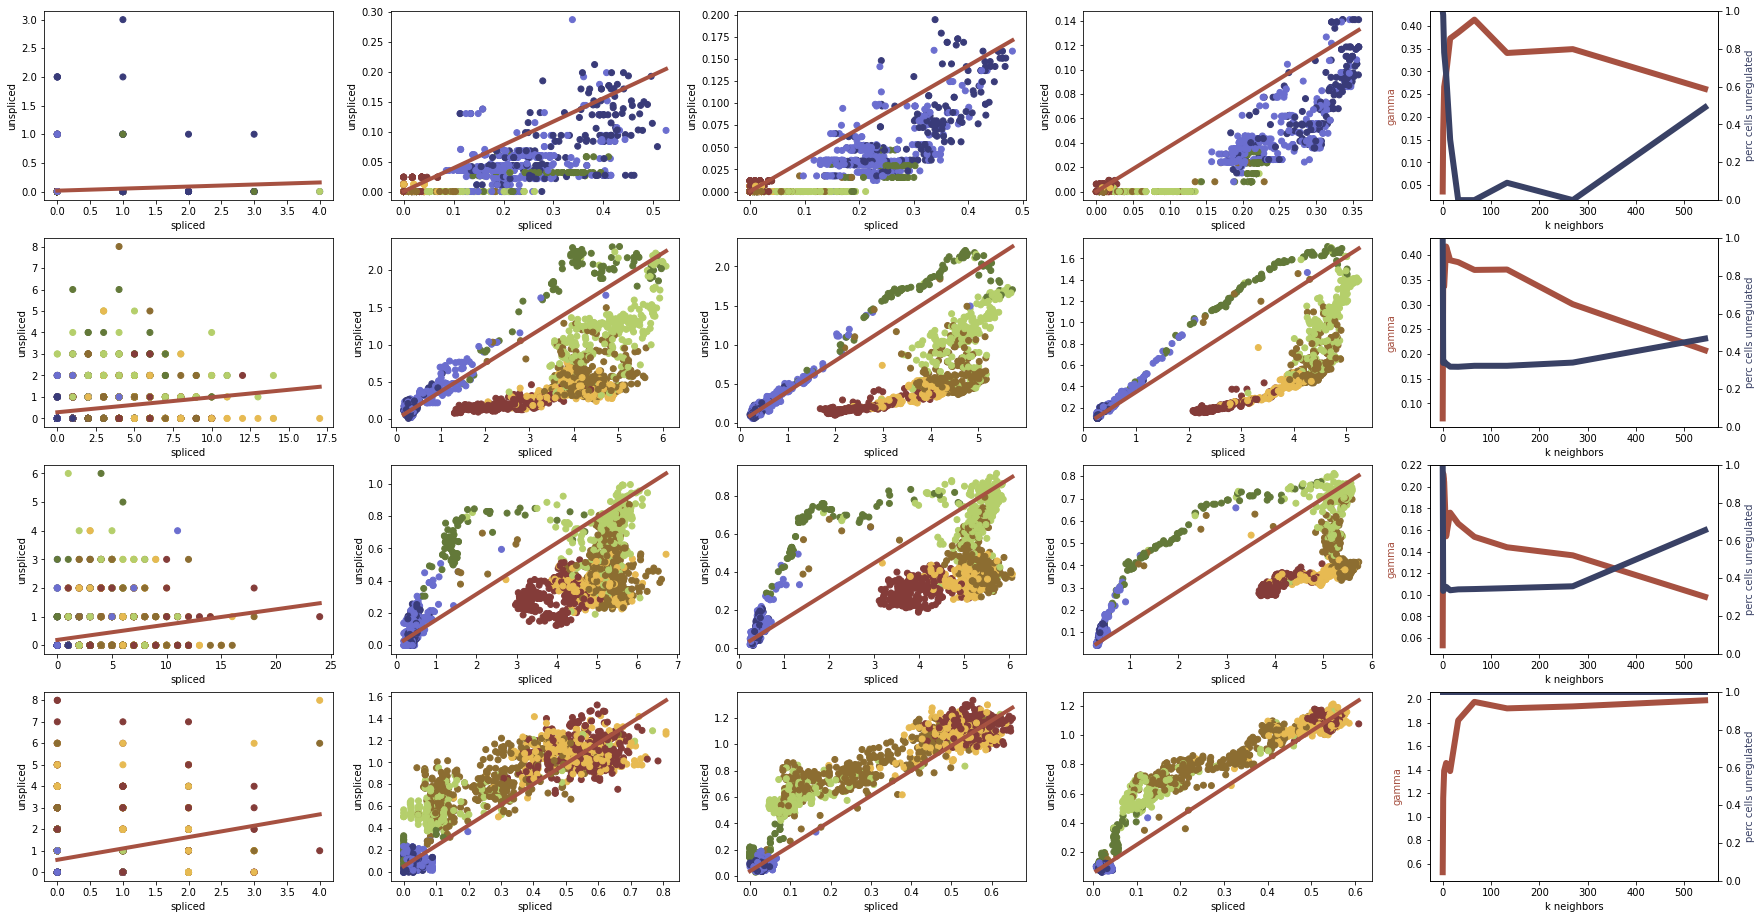

In [ ]:
import time 
t1 = time.time()
fig=phasePlots(vlm,genes=["FAM64A","ELAVL4","DCX","GRIA3"],n_neighs=[0,50,100,200],n_neighs_list=np.exp(np.arange(0,7,0.7))-1,sim=False)
dtime = time.time()-t1

In [ ]:
print('Runtime: {:.1f} seconds.'.format(dtime))

Runtime: 52.6 seconds.


In [ ]:
fig.savefig('../figure/figure_6.png',dpi=450)
fig.savefig('../figure/figure_6.pdf')

**Make Fig. 1 Plots** 
Example phase portrait
Example velocity embedding

In [ ]:
gene_idx_spec=int(np.where(vlm.ra['Gene']=="ELAVL4")[0][0])

In [ ]:
getImputed(vlm, knn_k=50)

In [ ]:
def plotPhase2(ax, vlm, gene_idx):
    '''
    Plot phase portrait
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    y=vlm.Ux[gene_idx,:]
    x=vlm.Sx[gene_idx,:]
    k=vlm.gammas[gene_idx]
    b=vlm.q[gene_idx]
    
    ax.scatter(x, y, c=vlm.colors)
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    x_=np.array([np.amin(x), np.amax(x)])
    ax.plot(x_, x_*k+b, color='black',linewidth=4,linestyle='dashed')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

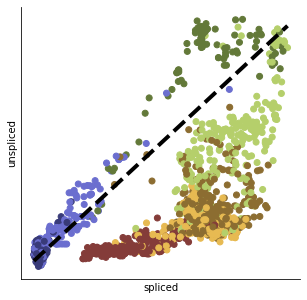

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plotPhase2(ax, vlm, gene_idx_spec)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.savefig('phase.pdf')
#vlm.delta_S = vlm.Ux_sz - vlm.gammas[:,None] * vlm.Sx_sz


In [ ]:
def plotEmbed2(ax,vlm,embed,s=50,alpha=0.6):
    '''
    Plot given embedding (UMAP, t-SNE, etc)
    
    Parameters
    ----------
    c: colors

    Returns
    -------
    '''
    x=getattr(vlm, embed)
    ax.scatter(x[:,0],x[:,1],marker=".",c=vlm.colors,s=s, alpha=alpha,edgecolors="none")
    return

In [ ]:
def gridArrowPlots2(vlm,Trans,embed,sim=False,meta=None,ax=None,legend=True,quiver_scale=5):
    '''
    Plot arrow embeddings for vlm data with defined count transformations
    
    Parameters
    ----------
    sim: boolean to look for true pseudotime or cluster and/or principal curve
    
    Returns
    -------
    
    '''
    if not hasattr(vlm,"delta_S"):
        getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='S_norm', new_pca=False)
    emb=emb_dict[embed]
    if ax is None:
        fig,ax=plt.subplots(1,1)
        
    plotEmbed2(ax,vlm,emb,s=300,alpha=0.6)
    
    # plot baseline arrows or curves
    if embed=="PCA":
        if sim:
            princCurvePlots(ax,vlm,meta)
        else:
            v=linear_embed(vlm)
            #ax.quiver(vlm.pcs[:,0], vlm.pcs[:,1], v[:, 0], v[:, 1], alpha=0.5, linewidth=6.5, scale=5, label="baseline")       

    for i,trans in enumerate(Trans):        
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                n_neighbors=150, knn_random=False, sampled_fraction=1)

        if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
            warnings.warn("Nan values in corrcoef, setting them to 0") 
            vlm.corrcoef[np.isnan(vlm.corrcoef)]=0

        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        vlm.calculate_grid_arrows(smooth=0.5, steps=(10, 10), n_neighbors=100)

        plotGrid(ax,vlm,"flow_grid","flow",trans, scale=quiver_scale, c='black')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    if legend:
        ax.legend()
    if ax is None:
        return fig
    else:
        return ax

In [ ]:
# fig, ax = plt.subplots(figsize=(7,5))
# gridArrowPlots2(vlm,Trans=["sqrt"],embed="PCA",sim=False,ax=ax,quiver_scale=10) #tSNE
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# plt.savefig('velocity.pdf')

### Grid Embedding

From velocyto default workflow

In [ ]:
vlm = vcy.VelocytoLoom("data/hgForebrainGlut.loom")

labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [ ]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [ ]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

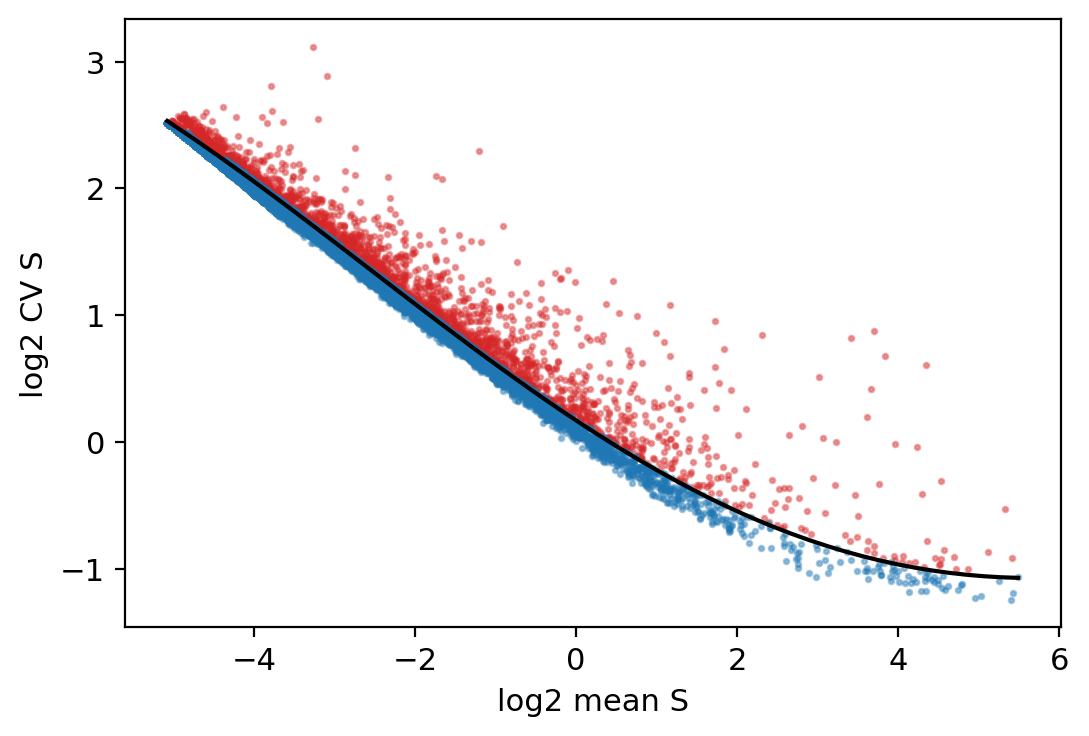

In [ ]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [ ]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

In [ ]:
vlm.perform_PCA()
#plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 

In [ ]:
!pip install igraph --quiet

     |████████████████████████████████| 3.1 MB 5.4 MB/s 


In [ ]:
from sklearn.neighbors import NearestNeighbors
import igraph

nn = NearestNeighbors(n_neighbors=50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [ ]:
from numpy_groupies import aggregate, aggregate_np


In [ ]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))


In [ ]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [ ]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [ ]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [ ]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [ ]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

In [ ]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

In [ ]:
# labels = vlm.ca["Clusters"]
# cluster_colors_dict={l:colors20[l % 20,:] for l in labels}
# vlm.colors=[cluster_colors_dict[label] for label in labels]

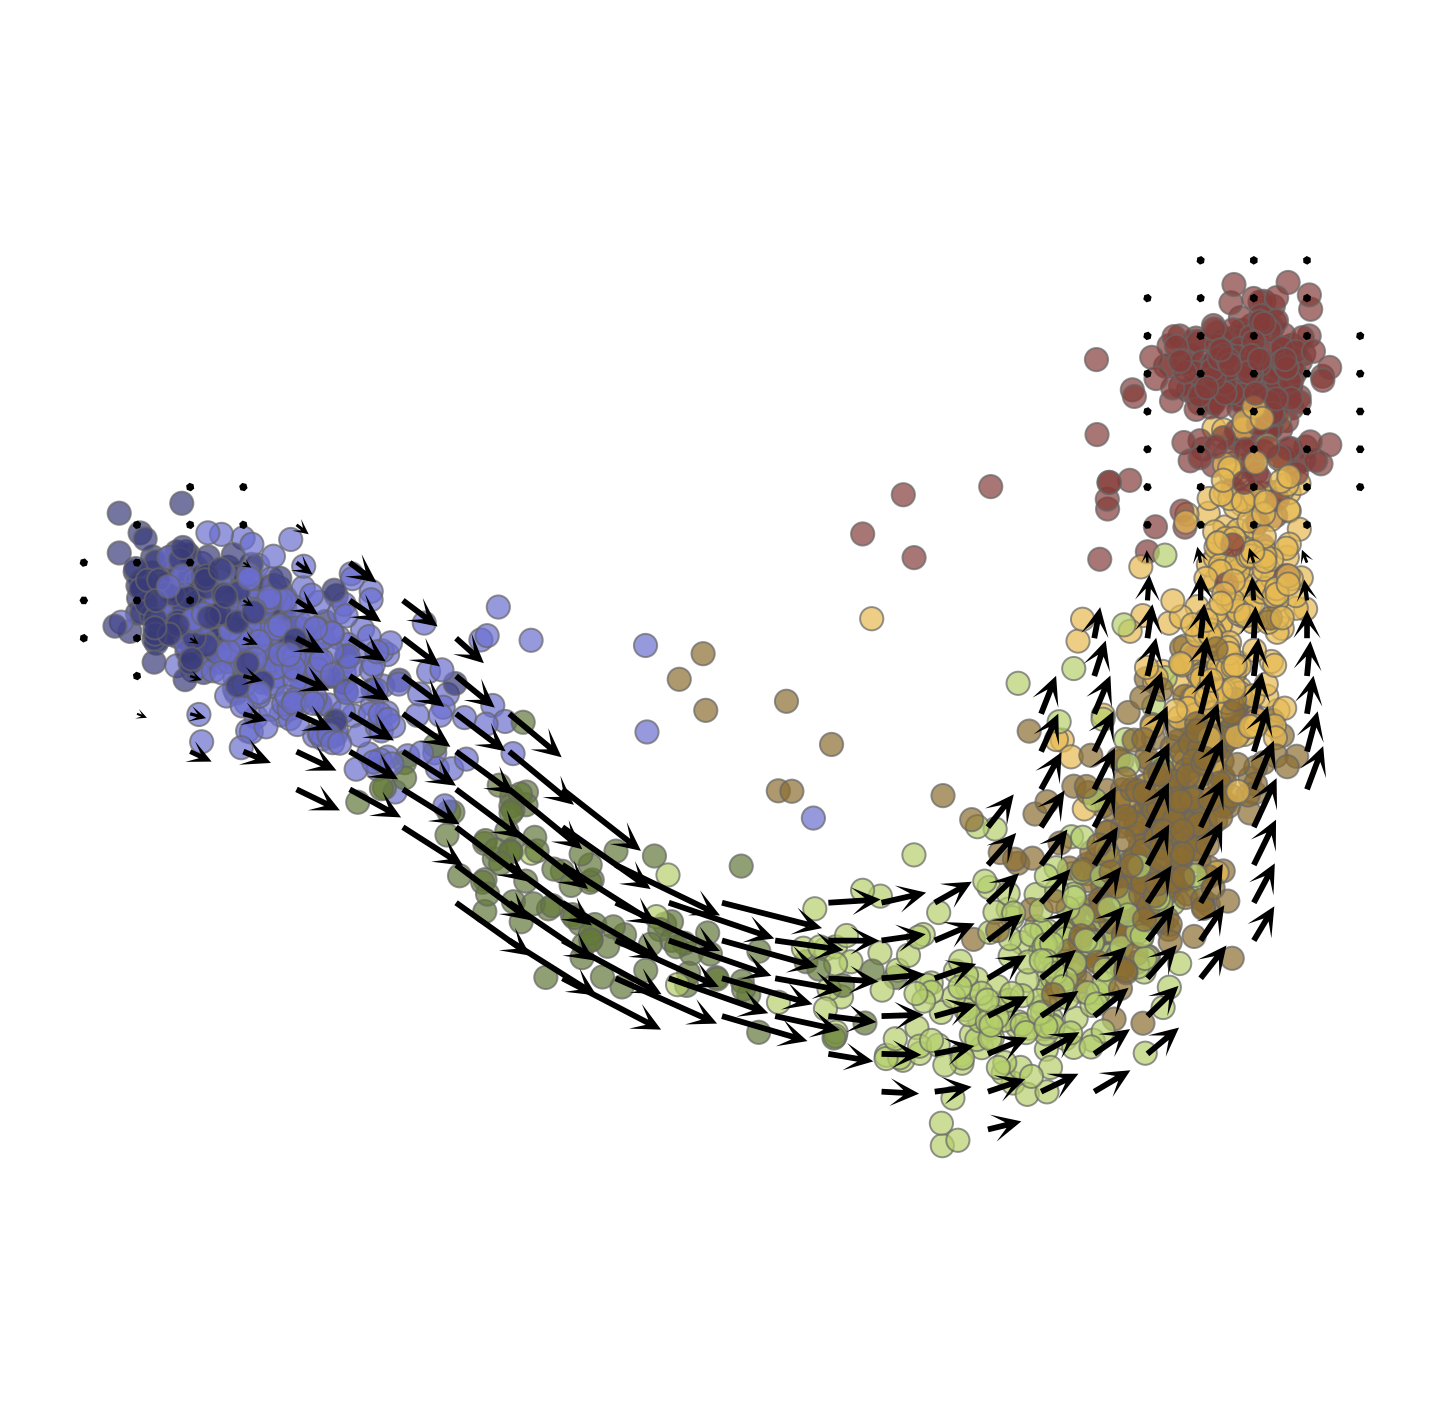

In [ ]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
# plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
# plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

## scvelo

In [ ]:
# update to the latest version, if not done yet.
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.3 (python 3.7.12) on 2022-01-29 23:51.


In [ ]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [ ]:
adata = scv.read('data/hgForebrainGlut.loom', cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 26764 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
adata

AnnData object with n_obs × n_vars = 1720 × 2000
    obs: 'Clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [ ]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
#Get colors

In [ ]:
labels = vlm.ca["Clusters"]
cluster_colors_dict={str(l):colors20[l % 20,:] for l in labels}
#colors=[cluster_colors_dict[label] for str(label) in labels]

In [ ]:
cluster_colors_dict

{'0': array([0.22352941, 0.23137255, 0.4745098 , 1.        ]),
 '1': array([0.41960784, 0.43137255, 0.81176471, 1.        ]),
 '2': array([0.38823529, 0.4745098 , 0.22352941, 1.        ]),
 '3': array([0.70980392, 0.81176471, 0.41960784, 1.        ]),
 '4': array([0.54901961, 0.42745098, 0.19215686, 1.        ]),
 '5': array([0.90588235, 0.72941176, 0.32156863, 1.        ]),
 '6': array([0.51764706, 0.23529412, 0.22352941, 1.        ])}

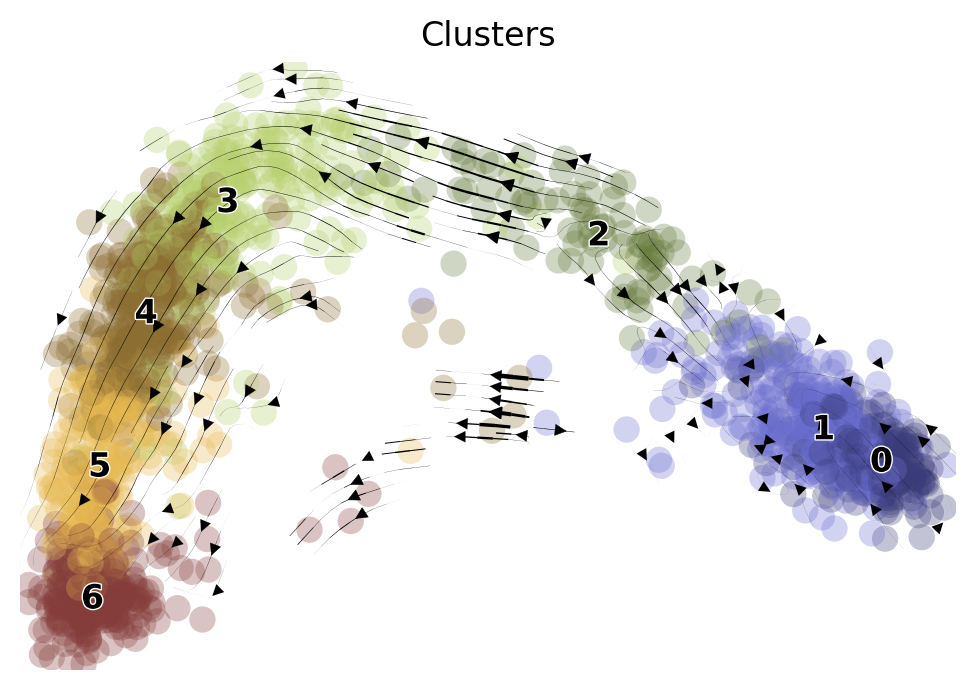

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='pca',color='Clusters',palette=cluster_colors_dict)
